In [1]:
# Importing numpy and 

import numpy as np
from numpy import genfromtxt
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import random

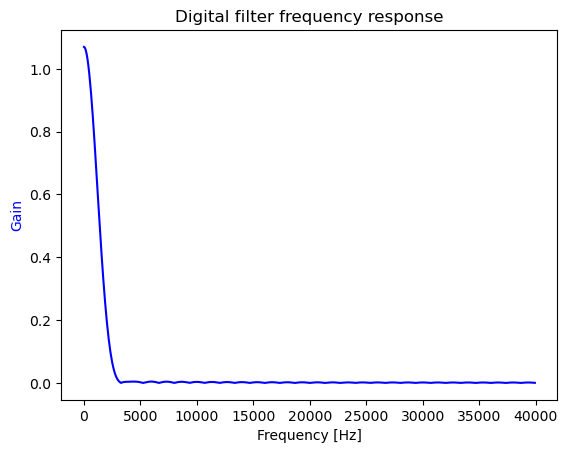

In [59]:
# Signal parameters
freq1 = 100
freq2 = 300
freq3 = 500

# Noise Parameters
noiseAmplitude = 1.0

# FIR Parameters
Fs = 80000
freq_low, freq_high = 50, 800 #


try:
    b = signal.firwin(60, [freq_low, freq_high], fs = Fs, pass_zero=False)
except ValueError:
    print(f"Sampling freq of {Fs} below Nyquist, increase to at least {2*freq_high+1}")


# Plotting frequency response
w, h = scipy.signal.freqz(b)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(0.5*w/np.pi * Fs, abs(h), 'b')
ax1.set_ylabel('Gain', color='b')
ax1.set_xlabel('Frequency [Hz]')
plt.show()



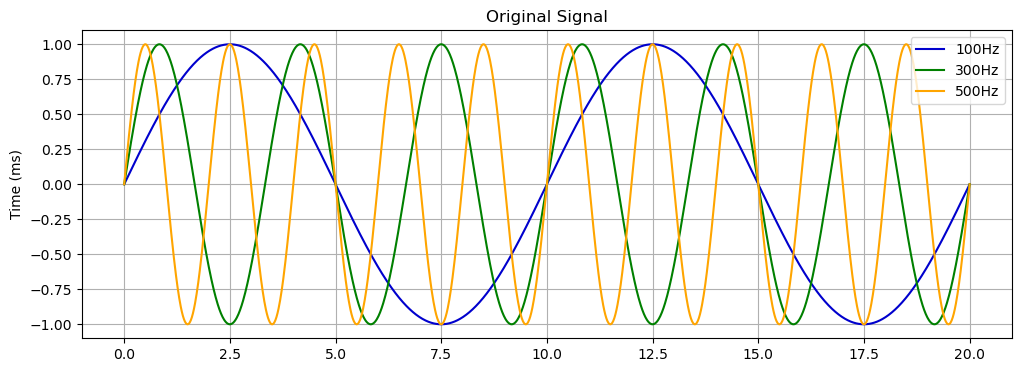

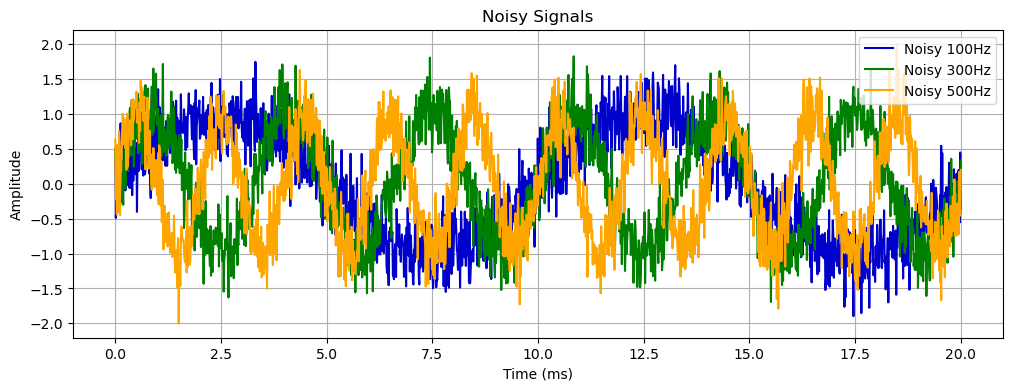

In [63]:
# Data generation
numPeriods = 6

# Use highest frequency
endTime = numPeriods/freq2
num = int(endTime * Fs)

time = np.linspace(start=0, stop=endTime, num = int(endTime*Fs))
signal1 = np.sin(2*np.pi*freq1*time)
signal2 = np.sin(2*np.pi*freq2*time)
signal3 = np.sin(2*np.pi*freq3*time)

# Generate random noise
noise_amplitude = 0.30  # Adjust the amplitude of the noise as needed
noise1 = noise_amplitude * np.random.randn(len(time))
noise2 = noise_amplitude * np.random.randn(len(time))
noise3 = noise_amplitude * np.random.randn(len(time))

signal1_noisy = signal1 + noise1
signal2_noisy = signal2 + noise2
signal3_noisy = signal3 + noise3

# Plot clean signals
plt.figure(figsize=(12, 4))
plt.plot(time*1000,signal1, label=f"{freq1}Hz", color='mediumBlue')
plt.plot(time*1000,signal2, label=f"{freq2}Hz", color='green')
plt.plot(time*1000,signal3, label=f"{freq3}Hz", color='orange')
plt.title("Original Signal")
plt.ylabel("Time (ms)")
plt.legend(loc='upper right') 
plt.grid(True)
plt.show()

# Plot noisy signals
plt.figure(figsize=(12, 4))
plt.plot(time * 1000, signal1_noisy, label=f"Noisy {freq1}Hz", color='mediumBlue')
plt.plot(time * 1000, signal2_noisy, label=f"Noisy {freq2}Hz", color='green')
plt.plot(time * 1000, signal3_noisy, label=f"Noisy {freq3}Hz", color='orange')
plt.title("Noisy Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right') 
plt.grid(True)
plt.show()

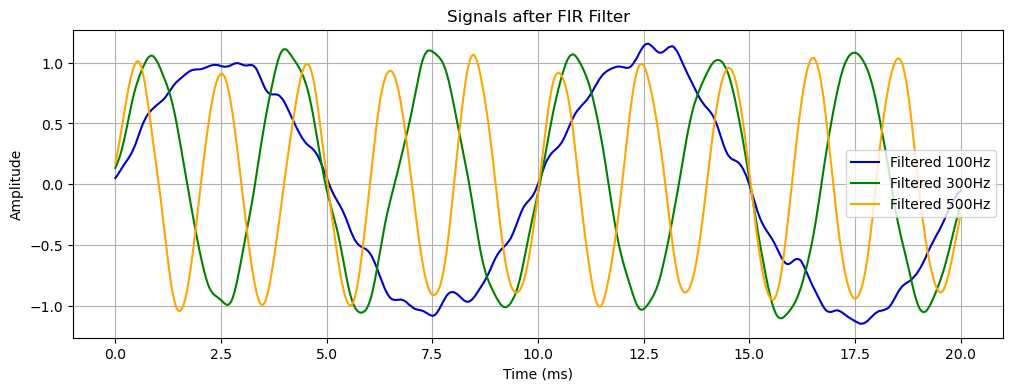

In [64]:
# Testing the filter

filtered_signal1 = signal.convolve(signal1_noisy, b, mode='same')
filtered_signal2 = signal.convolve(signal2_noisy, b, mode='same')
filtered_signal3 = signal.convolve(signal3_noisy, b, mode='same')

plt.figure(figsize=(12,4))
plt.plot(time*1000, filtered_signal1, label=f'Filtered {freq1}Hz', color='mediumBlue')
plt.plot(time*1000, filtered_signal2, label=f'Filtered {freq2}Hz', color='green')
plt.plot(time*1000, filtered_signal3, label=f'Filtered {freq3}Hz', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signals after FIR Filter')
plt.legend()
plt.grid(True)
plt.show()


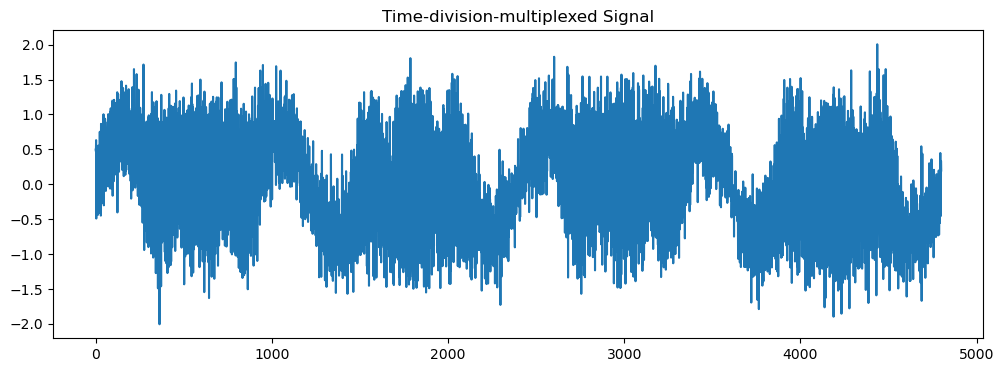

In [65]:
# TDM signal generation

# Create an array that alternates data between signals 1, 2, and 3
TDM_signal = []
for i in range (0, len(signal1_noisy)):
    TDM_signal.append (signal1_noisy[i])
    TDM_signal.append (signal2_noisy[i])
    TDM_signal.append (signal3_noisy[i])


# ////// FIFO Parameters
# Delay line is length M*(N-1)
M = 3      # number of channels
N = len(b) # number of filter taps
buff_len = M*(N-1)
delayLine = np.zeros(buff_len) # size of the delay line

plt.figure(figsize=(12,4))
plt.title("Time-division-multiplexed Signal")
plt.plot(TDM_signal)
plt.show()


In [68]:
import time as timeModule

y1 = []
y2 = []

# Architecture 1
# 1 FIFO for each tap and each FIFO has M lots, M is the number of channels

start_time = timeModule.time()

# FIFO creation
s = (N, M)
FIFO = np.zeros(s)

for i in range (len(TDM_signal)):
    for j in reversed(range(0,N)):
        FIFO[j]   = np.roll(FIFO[j], 1) # shift over
        
        if (j >= 1):
            FIFO[j, 0] = FIFO[j-1,M-1]

    # Feed new data into the first FIFO
    FIFO[0, 0] = TDM_signal[i]
    multAcc    = np.dot(b,FIFO[:,2]) 
    y1.append(multAcc)


TDM_1_arch1 = y1[2::3]
TDM_2_arch1 = y1[0::3]
TDM_3_arch1 = y1[1::3]

end_time = timeModule.time()
Arch1ExecTime = elapsed_time = end_time - start_time
print(f"Arch 1 Execution time = {Arch1ExecTime}")

# start_time = timeModule.time()

# Architecture 2
# N-1 FIFOs and each FIFO is of size M+1
# s = (N-1, M+1)
# FIFO = np.zeros(s)

# index = 0
# for i in range (int(len(TDM_signal) * (M+1)/M)-1):
#     for j in reversed(range(0,N-1)):
#         FIFO[j]   = np.roll(FIFO[j], 1) # shift over
        
#         if (j >= 1):
#             FIFO[j, 0] = FIFO[j-1,M] # send values to next FIFO

#     # Feed new data into the first FIFO
#     # restrict write operations to occur every M+1 spots
#     if (i % 4 != 0):
#         FIFO[0, 0] = TDM_signal[index] # feed values into FIFO chain
#         index += 1
#     else:
#         FIFO[0,0] = None

#     multAcc    = np.dot(b[1:],FIFO[:,3])  + b[0] * TDM_signal[index]
#     y2.append(multAcc)


# TDM_1_arch2 = y2[0::4]
# TDM_2_arch2 = y2[1::4]
# TDM_3_arch2 = y2[2::4]

# end_time = timeModule.time()
# Arch2ExecTime = elapsed_time = end_time - start_time

# print(f"Arch 2 Execution time = {Arch2ExecTime}")


Arch 1 Execution time = 4.057699203491211


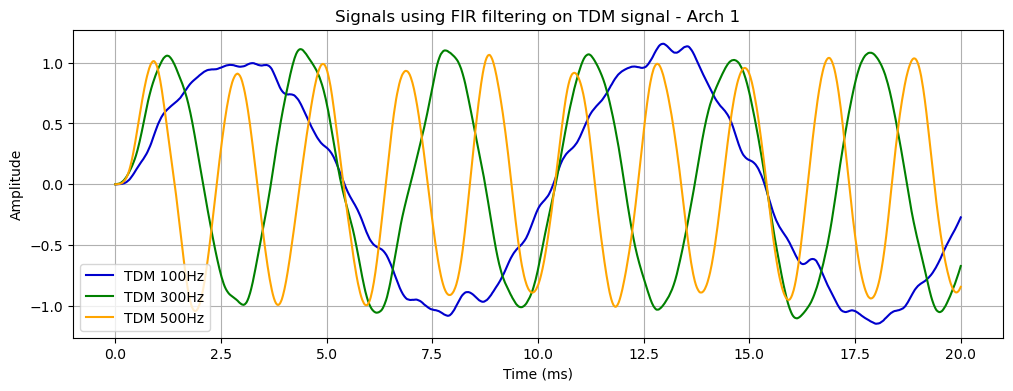

In [ ]:
# plt.figure(figsize=(12,4))
# plt.title('Time-division-multiplexed signal after filtering')
# plt.plot(y2)

# Architecture 1 plot
plt.figure(figsize=(12,4))
plt.plot(time*1000, TDM_1_arch1, label=f'TDM {freq1}Hz', color='mediumBlue')
plt.plot(time*1000, TDM_2_arch1, label=f'TDM {freq2}Hz', color='green')
plt.plot(time*1000, TDM_3_arch1, label=f'TDM {freq3}Hz', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signals using FIR filtering on TDM signal')
plt.legend()
plt.grid(True)
plt.show()

# #Architecture 2 plot
# plt.figure(figsize=(12,4))
# plt.plot(time*1000, TDM_1_arch2, label=f'TDM {freq1}Hz', color='mediumBlue')
# plt.plot(time*1000, TDM_2_arch2, label=f'TDM {freq2}Hz', color='green')
# plt.plot(time*1000, TDM_3_arch2, label=f'TDM {freq3}Hz', color='orange')
# plt.xlabel('Time (ms)')
# plt.ylabel('Amplitude')
# plt.title('Signals using FIR filtering on TDM signal - Arch 2')
# plt.legend()
# plt.grid(True)
# plt.show()